# Tail Angle Preprocessing

**The following notebook illustrate the `TailPreprocessing` class how to run the different preprocessing steps.**
- **Several preprocessing steps are used for the tail angle**:
  - Interpolating missing values
  - PCA denoising of posture using 'eigen-fish'
  - Savgol filter for time series smoothing
  - Baseline correction

- **The tail vigor is also computed and will be useful for detecting tail bouts**



* Loading dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from megabouts.tracking_data import TrackingConfig, FullTrackingData, load_example_data
from megabouts.config import TailPreprocessingConfig
from megabouts.preprocessing import TailPreprocessing

## Loading Data

* TrackingConfig and TrackingData similar to [tutorial_Loading_Data](./Loading_Data.ipynb), here we use the dataset from the poorly trained SLEAP model to underlie the effect of smoothing.

In [2]:
# Load data and set tracking configuration
df_recording, fps, mm_per_unit = load_example_data("SLEAP_fulltracking")
tracking_cfg = TrackingConfig(fps=fps, tracking="full_tracking")

# List of keypoints
keypoints = ["left_eye", "right_eye", "tail0", "tail1", "tail2", "tail3", "tail4"]

# Place NaN where the score is below a threshold
thresh_score = 0.0
for kps in keypoints:
    score_below_thresh = df_recording["instance.score"] < thresh_score
    df_recording.loc[
        score_below_thresh | (df_recording[f"{kps}.score"] < thresh_score),
        [f"{kps}.x", f"{kps}.y"],
    ] = np.nan

# Compute head and tail coordinates and convert to mm
head_x = ((df_recording["left_eye.x"] + df_recording["right_eye.x"]) / 2) * mm_per_unit
head_y = ((df_recording["left_eye.y"] + df_recording["right_eye.y"]) / 2) * mm_per_unit
tail_x = df_recording[[f"tail{i}.x" for i in range(5)]].values * mm_per_unit
tail_y = df_recording[[f"tail{i}.y" for i in range(5)]].values * mm_per_unit

# Create FullTrackingData object
tracking_data = FullTrackingData.from_keypoints(
    head_x=head_x.values, head_y=head_y.values, tail_x=tail_x, tail_y=tail_y
)

## Run Preprocessing

* Define preprocessing config using default:

In [3]:
tail_preprocessing_cfg = TailPreprocessingConfig(fps=tracking_cfg.fps)
print(tail_preprocessing_cfg)

TailPreprocessingConfig(fps=350, limit_na_ms=100, num_pcs=4, savgol_window_ms=15, baseline_method='median', baseline_params={'fps': 350, 'half_window': 175}, tail_speed_filter_ms=100, tail_speed_boxcar_filter_ms=14)


* Alternatively the tail preprocessing parameters can be set to custom values using:

In [4]:
tail_preprocessing_cfg = TailPreprocessingConfig(
    fps=tracking_cfg.fps,
    num_pcs=3,
    savgol_window_ms=30,
    tail_speed_filter_ms=100,
    tail_speed_boxcar_filter_ms=14,
)

* Here we change the median filter for computing the tail baseline to 200 frame width:

In [5]:
tail_preprocessing_cfg.baseline_params["half_window"] = 100

* Let's run the preprocessing pipeline:

In [6]:
tail_df_input = tracking_data.tail_df
tail = TailPreprocessing(tail_preprocessing_cfg).preprocess_tail_df(tail_df_input)

* tail.df contains information about the raw angle, the baseline, the smooth angle as well as the vigor of the tail oscillations:

In [7]:
tail.df.head(5)

angle                                                              \
   segments                                                               
          0         1         2         3         4         5         6   
0  0.122614 -0.015221 -0.098553 -0.126124 -0.098301 -0.015937  0.062022   
1  0.122639 -0.015076 -0.098353 -0.125934 -0.098185 -0.015953  0.061969   
2  0.122712 -0.015160 -0.098521 -0.126112 -0.098298 -0.015927  0.062090   
3  0.182927  0.045016 -0.038378 -0.065993 -0.038198  0.044170  0.122267   
4  0.182883  0.045139 -0.038150 -0.065731 -0.037968  0.044304  0.122333   

                                 ... angle_smooth                      \
                                 ...     segments                       
          7         8         9  ...            2         3         4   
0  0.057392 -0.035583 -0.215341  ...    -0.100224 -0.096774 -0.067329   
1  0.057438 -0.035308 -0.214723  ...    -0.086259 -0.081402 -0.051451   
2  0.057466 -0.035575 -0.215469  ...    -0.077366 -0.071614 -0.041347   
3  0.117708  0.024690 -0.155223  ...    -0.073543 -0.067412 -0.037017   
4  0.117786  0.024859 -0.154890  ...    -0.074792 -0.068794 -0.038462   

                                                    no_tracking vigor  
                                                                       
          5         6         7         8         9                    
0 -0.018151  0.056155  0.058781 -0.090561 -0.172721       False   NaN  
1 -0.002093  0.069939  0.071179 -0.076765 -0.157507       False   NaN  
2  0.008123  0.078698  0.079057 -0.067974 -0.147809       False   NaN  
3  0.012494  0.082430  0.082415 -0.064188 -0.143629       False   NaN  
4  0.011022  0.081137  0.081254 -0.065407 -0.144965       False   NaN  

[5 rows x 32 columns]

* We can visualize the result of preprocessing:

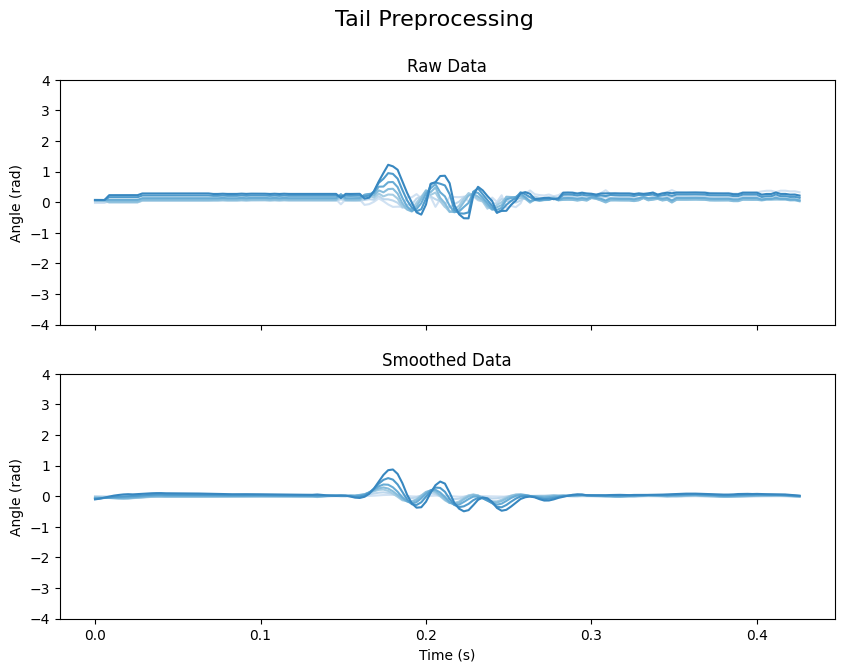

In [8]:
from cycler import cycler

blue_cycler = cycler(color=plt.cm.Blues(np.linspace(0.2, 0.9, 10)))

t = np.arange(tracking_data.T) / tracking_cfg.fps
IdSt = 140612  # np.random.randint(tracking_data.T)
Duration = 150
t_win = t[IdSt : IdSt + Duration] - t[IdSt]

# Prepare the data, titles, and subtitles
angle_data = [tail.angle, tail.angle_smooth]
subtitles = ["Raw Data", "Smoothed Data"]

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

# Set a main title for the figure
fig.suptitle("Tail Preprocessing", fontsize=16)

# Loop over the axes, data, and subtitles
for axis, data, subtitle in zip(ax, angle_data, subtitles):
    axis.set_prop_cycle(blue_cycler)
    axis.plot(t_win, data[IdSt : IdSt + Duration, :7])
    axis.set(ylabel="Angle (rad)", ylim=(-4, 4))
    axis.set_title(subtitle, fontsize=12)

# Set x-label for the last subplot
ax[-1].set_xlabel("Time (s)")
plt.show()

> ### 📝 Note
> Smoothing the tail tracking data is optional for classifying tail bouts. The transformer model was trained on raw tracking data, so it can handle unsmoothed input just as well.